In [1]:
import pandas as pd
import numpy  as np
from os import listdir
from os.path import isfile, join
import re
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
import data_tools
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.optimize import least_squares
from scipy import stats
import statsmodels.api as sm
import calendar
from my_time_series import (
    fit_AR_LS,
    residuals_AR,
    tests_gaussian_white_noise, 
)

from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

import data_tools
import itertools

from matplotlib import cm
from scipy.stats import norm
from Models.models import *
from time import time

from scipy.optimize import leastsq
import scipy.stats as spst
from numba import jit
from tabulate import tabulate

## Load data

In [3]:
def initial_values(num_coefs):
    p0 = {}
    for i in range(num_coefs):
        p0[f'coefs{i}'] = 0
        
    return p0

class NLS:
    ''' This provides a wrapper for scipy.optimize.leastsq to get the relevant output for nonlinear least squares. 
    Although scipy provides curve_fit for that reason, curve_fit only returns parameter estimates and covariances. 
    This wrapper returns numerous statistics and diagnostics'''


    def __init__(self, func, p0, xdata, ydata):
        # Check the data
        if len(xdata) != len(ydata):
            msg = 'The number of observations does not match the number of rows for the predictors'
            raise ValueError(msg)

        # Check parameter estimates
        if type(p0) != dict:
            msg = "Initial parameter estimates (p0) must be a dictionry of form p0={'a':1, 'b':2, etc}"
            raise ValueError(msg)

        self.func  = func
        self.inits = list(p0.values())
        self.xdata = xdata
        self.ydata = ydata
        self.nobs  = len( ydata )
        self.nparm = len( self.inits )

        self.parmNames = p0.keys()

        # Run the model
        self.mod1 = leastsq(self.func, self.inits, full_output=1)

        # Get the parameters
        self.parmEsts = np.round( self.mod1[0], 4)

        # Get the Error variance and standard deviation
        self.RSS  = np.sum( self.mod1[2]['fvec']**2 ) # RSS
        self.df   = self.nobs - self.nparm            # degrees of freedom
        self.MSE  = self.RSS / self.df                # mean squared error
        self.RMSE = np.sqrt( self.MSE )               # root mean squared error

        # Get the covariance matrix
        self.cov = self.MSE * self.mod1[1] # it is not clear what mod1[1] is

        # Get parameter standard errors
        self.parmSE = np.sqrt( np.diag( self.cov ) )

        # Calculate the t-values
        self.tvals = self.parmEsts/self.parmSE

        # Get p-values
        self.pvals = (1 - spst.t.cdf( np.abs(self.tvals), self.df))*2

        # Get biased variance (MLE) and calculate log-likehood
        self.s2b = self.RSS / self.nobs
        self.logLik = -self.nobs/2 * np.log(2*np.pi) - self.nobs/2 * np.log(self.s2b) - 1/(2*self.s2b) * self.RSS

        del(self.mod1)
        del(self.s2b)
        del(self.inits)

    # Get AIC. Add 1 to the df to account for estimation of standard error
    def AIC(self, k=2):
        return -2*self.logLik + k*(self.nparm + 1)

    # Print the summary
    def summary(self):
        print('Non-linear least squares')
        print('Model: ' + self.func.__name__)
        table = [['Variable', 'Estimate', 'Std. Error', 't-value', 'P(>|t|)']]
        for i in range( len(self.parmNames) ):
                row = [f'{list(self.parmNames)[i]}', f'{self.parmEsts[i]:5.4f}', f'{self.parmSE[i]:5.4f}', f'{self.tvals[i]:5.4f}', f'{self.pvals[i]:5.4f}']
                table.append(row)
                
        print(tabulate(table, tablefmt='fancy_grid'))
        print(f'Residual Standard Error: {self.RMSE: 5.4f}')
        print(f'Df: {int(self.df)}')

### Raw preprocess

In [4]:
dam_id = 1112

path = data_tools.from_id_to_time_series(dam_id)

dam_ts = pd.read_csv(path)
data_tools.add_year_month_database(dam_ts)

dam_ts = dam_ts.groupby('yearmonth').mean()

dam_ts.index = dam_ts.index.astype(int)

In [5]:
ele_ts = pd.read_csv('APUS37A72610.csv')

## Convert string to numeric and interpolate missings (2 missings in electricity prices)

for idx in range(len(ele_ts.APUS37A72610)):
    
    elem = ele_ts.APUS37A72610[idx]
    if elem == '.':
        a = ele_ts.APUS37A72610[idx-1]
        b = eval(ele_ts.APUS37A72610[idx+1])
        
        ele_ts.APUS37A72610[idx] = (a+b)/2
        
    else:
        ele_ts.APUS37A72610[idx] = eval(elem)
        
## Convert DATE to yearmonth

for idx in ele_ts.index:
        date = ele_ts.loc[idx,'DATE']
        date = date.split('-')

        if np.isnan(ele_ts.APUS37A72610[idx]):
            continue

        ele_ts.loc[idx,'yearmonth'] = eval(date[0] + date[1])
        
ele_ts = ele_ts.drop('DATE',axis=1)
ele_ts = ele_ts.set_index('yearmonth')
ele_ts.index = ele_ts.index.astype(int)

In [6]:
## set same time intervales for both series

new_index = dam_ts.index.intersection(ele_ts.index)

dam_ts = dam_ts.loc[new_index,:]
ele_ts = ele_ts.loc[new_index,:]

ts = ele_ts.merge(dam_ts, left_index=True, right_index=True)
ts = ts.rename(columns= {'APUS37A72610': 'price'})

In [7]:
yearmonth = list(ts.index)
x_label   = data_tools.from_index_to_dates(yearmonth)

In [8]:
ts = ts.iloc[302:,:]
x_label = x_label[302:]

In [9]:
ts.to_csv('Preprocessed_data/ts.csv')

In [10]:
prices_data = pd.read_csv('prices_processed.csv', index_col=0)
start = np.where(prices_data.index == 'Jan 2004')[0][0]
end   = np.where(prices_data.index == 'Jan 2020')[0][0]
new_prices = prices_data.iloc[start:end, -1].values

ts = pd.read_csv('Preprocessed_data/ts.csv')
ts.loc[:,'price'] = new_prices

In [11]:
ts

,yearmonth,price,storage,inflow,outflow,elevation,evaporation
0,200401,7.31,2423.144516,64.557774,38.687065,174.703871,2.294
1,200402,7.24,2556.166034,96.107276,46.154448,175.564310,2.945
2,200403,7.27,2588.537645,79.366548,52.743226,175.769871,4.587
3,200404,7.52,2638.082300,78.393133,37.528267,176.078700,5.578
4,200405,7.86,2668.301839,46.613065,58.082258,176.266323,6.569
...,...,...,...,...,...,...,...
187,201908,9.45,2352.248000,21.151742,55.178516,174.229129,7.334
188,201909,9.09,2255.985500,20.976100,29.964867,173.568067,5.805
189,201910,8.66,2202.691774,27.515710,9.802129,173.194258,3.964
190,201911,8.52,2333.484000,83.207033,1.412100,174.099333,3.058


In [25]:
yearmonth = list(ts.yearmonth)
x_label   = data_tools.from_index_to_dates(yearmonth)

## Evaporation

In [12]:
def model_evaporation_0(coefs, t):
    return coefs[0] + coefs[1] * np.sin((coefs[2]+t)*2*np.pi/12)

evaporation = ts.evaporation.values
times       = np.arange(0,len(ts.index),1)

def residuals_evaporation(coefs):
    return model_evaporation_0(coefs, times) - evaporation

# coefs           = list(np.zeros(3))
# res_evaporation = least_squares(residuals_evaporation, coefs)
# coefficients_evaporation = res_evaporation.x
num_coefs = 3
p0 = initial_values(num_coefs)
res_evaporation = NLS(residuals_evaporation, p0, xdata=times, ydata=evaporation)

In [13]:
res_evaporation.summary()

Non-linear least squares
Model: residuals_evaporation
╒══════════╤══════════╤════════════╤═══════════╤═════════╕
│ Variable │ Estimate │ Std. Error │ t-value   │ P(>|t|) │
├──────────┼──────────┼────────────┼───────────┼─────────┤
│ coefs0   │ 4.9601   │ 0.0178     │ 278.3951  │ 0.0000  │
├──────────┼──────────┼────────────┼───────────┼─────────┤
│ coefs1   │ 2.7452   │ 0.0252     │ 108.9507  │ 0.0000  │
├──────────┼──────────┼────────────┼───────────┼─────────┤
│ coefs2   │ -2.5472  │ 0.0175     │ -145.3087 │ 0.0000  │
╘══════════╧══════════╧════════════╧═══════════╧═════════╛
Residual Standard Error:  0.2469
Df: 189


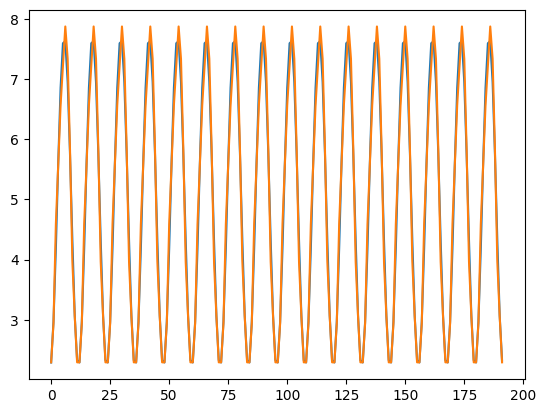

In [14]:
coefficients_evaporation = res_evaporation.parmEsts

np.savetxt('Models/coeficients/evaporation.csv', coefficients_evaporation, delimiter=',')

plt.plot(model_evaporation_0(coefficients_evaporation,times))
plt.plot(evaporation)
plt.show()

In [15]:
# Residuals 

residuals = model_evaporation_0(coefficients_evaporation,times) - evaporation

print(f'Evaporation residuals std: {np.std(residuals)}')

Evaporation residuals std: 0.24494001332739698


## Inflow

In [88]:
## Define the model.

inflows = ts.inflow.values
times   = np.arange(1,len(ts.index),1)

# def model_inflow_0(coefs,t):
#     return coefs[0]*inflows[t-1]+ coefs[1]*(1-coefs[0]) + (coefs[2] * (t% 12 == 1) + coefs[3] * (t% 12 == 2) + coefs[4] * (t% 12 == 3) \
#                                                            + coefs[5] * (t% 12 == 4) + coefs[6] * (t% 12 == 5) + coefs[7] * (t% 12 == 6)\
#                                                            + coefs[8] * (t% 12 == 7) + coefs[9] * (t% 12 == 8) + coefs[10] * (t% 12 == 9)\
#                                                            + coefs[11] * (t% 12 == 10)+ coefs[12] * (t% 12 == 11) + coefs[13] * (t% 12 == 0)) - coefs[0] \
#                                                            * (coefs[2] * (t-1% 12 == 1) + coefs[3] * (t-1% 12 == 2) + coefs[4] * (t-1% 12 == 3) \
#                                                            + coefs[5] * (t-1% 12 == 4) + coefs[6] * (t-1% 12 == 5) + coefs[7] * (t-1% 12 == 6)\
#                                                            + coefs[8] * (t-1% 12 == 7) + coefs[9] * (t-1% 12 == 8) + coefs[10] * (t-1% 12 == 9)\
#                                                            + coefs[11] * (t-1% 12 == 10)+ coefs[12] * (t-1% 12 == 11) + coefs[13] * (t% 12 == 0))

def model_inflow_0(coefs,t):
    return coefs[0] + coefs[1]* inflows[t-1] + coefs[2] * (np.sin((t+coefs[3])*2*np.pi/12))



def residuals_inflow(coefs):
    return model_inflow_0(coefs, times) - inflows[1:]

num_coefs = 4
p0 = initial_values(num_coefs)
inflow_res = NLS(residuals_inflow, p0, xdata=times, ydata=inflows[1:])

In [89]:
inflow_res.summary()

Non-linear least squares
Model: residuals_inflow
╒══════════╤══════════╤════════════╤═════════╤═════════╕
│ Variable │ Estimate │ Std. Error │ t-value │ P(>|t|) │
├──────────┼──────────┼────────────┼─────────┼─────────┤
│ coefs0   │ 51.7650  │ 6.4057     │ 8.0810  │ 0.0000  │
├──────────┼──────────┼────────────┼─────────┼─────────┤
│ coefs1   │ 0.2048   │ 0.0716     │ 2.8610  │ 0.0047  │
├──────────┼──────────┼────────────┼─────────┼─────────┤
│ coefs2   │ 31.3252  │ 6.5748     │ 4.7644  │ 0.0000  │
├──────────┼──────────┼────────────┼─────────┼─────────┤
│ coefs3   │ 1.3272   │ 0.3918     │ 3.3878  │ 0.0009  │
╘══════════╧══════════╧════════════╧═════════╧═════════╛
Residual Standard Error:  60.7318
Df: 187


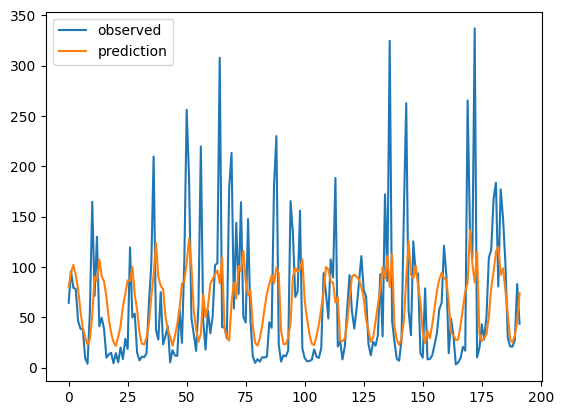

In [18]:
coefficients_inflow = inflow_res.parmEsts

np.savetxt('Models/coeficients/inflow_coef.csv', coefficients_inflow, delimiter=',')
np.savetxt('Models/coeficients/inflows.csv', inflows, delimiter=',')

plt.plot(inflows, label = 'observed')
plt.plot(model_inflow_0(coefficients_inflow,times), label = 'prediction')
plt.legend()
plt.show()

In [19]:
# Residuals 

residuals = model_inflow_0(coefficients_inflow,times[1:]) - inflows[1:]

print(f'Inflow residuals std: {np.std(residuals)}')

Inflow residuals std: 60.092621369282455


## Model storage

In [20]:
times   = np.arange(0,len(ts.index),1)

def model_storage_0(t):
    inflow      = model_inflow_0(coefficients_inflow, t)
    evaporation = model_evaporation_0(coefficients_evaporation,t)
    
    return ts.storage.values[t-1] + 2.592 * inflow - evaporation -  2.592 * ts.outflow.values[t-1]

In [21]:
prediction = model_storage_0(times[1:])

<ipython-input-75-6780eed51506>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(l)


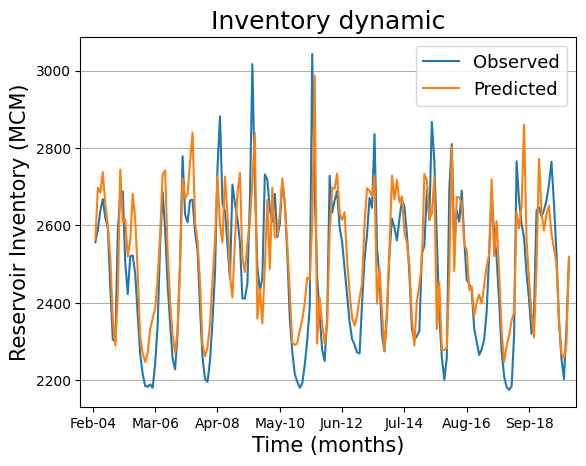

In [75]:
plt.plot(times[1:], ts.storage[1:],label = 'Observed')
plt.plot(times[1:], prediction[:],label = 'Predicted')
plt.locator_params(axis='x', nbins=8)
plt.xlim(-5,194)
ax = plt.gca()
x = ax.get_xticks
l = []
for e in x()[:]:
    year, month = divmod(int(e) + 1, 12)
    year  += 4
    if year < 10:
        year = f'0{year}'
    month += 1
    month = calendar.month_name[month][:3]
    l.append(f'{month}-{year}')
ax.set_xticklabels(l)
plt.grid(axis='y')
plt.title('Inventory dynamic', fontdict={'size': 18})
plt.xlabel('Time (months)',fontdict={'size':15})
plt.ylabel('Reservoir Inventory (MCM)',fontdict={'size':15})
plt.legend(fontsize = 13)
plt.savefig('Figures/paper/Inventory_dynamic.pdf', format = 'pdf')
plt.show()

In [23]:
# Residuals 

residuals = ts.storage[1:] - prediction

print(f'Storage residuals std: {np.std(residuals)}')

Storage residuals std: 103.79512935238394


## Electricity prices

In [7]:
prices = ts.price.values
times  = np.arange(1,len(prices),1)

### Linear regression, integration

In [8]:
x = np.array(prices[:-1])
x = x.transpose()

In [16]:
x = sm.add_constant(x)
result = sm.OLS(prices[1:], x).fit()

In [10]:
sigma = np.cov(prices[1:], prices[:-1])

beta_hat = sigma[0,1]/(sigma[1,1])
print(beta_hat)

0.9473261611517437


In [18]:
v_hat = np.inner(result.resid, result.resid) / (len(result.resid) - 2)

dif_mean    = prices[:-1] - np.mean(prices[:-1])
denominator = np.inner(dif_mean, dif_mean)

error_beta = np.sqrt(v_hat / denominator)

print(error_beta)

0.02141573581383853


In [19]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     1957.
Date:                Mon, 28 Nov 2022   Prob (F-statistic):          1.19e-101
Time:                        16:52:35   Log-Likelihood:                -17.180
No. Observations:                 191   AIC:                             38.36
Df Residuals:                     189   BIC:                             44.86
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4822      0.195      2.474      0.0

### It is not clear wether differentiation is needed or not, we will differentiate to make sure it is stationary

In [23]:
prices          = ts.price.values
log_prices      = np.log(prices)
diff_log_prices = np.diff(log_prices)

times = np.arange(1,len(prices),1)

In [21]:
%%latex

We fit the two models observed in the fishery paper:
    
\begin{equation}
\Delta ln(P_{t+1}) = \nu_P + \sigma_P \epsilon_{t+1}^P
\end{equation}

\begin{equation}
\Delta ln(P_{t+1}) = \theta_P \; (\mu_P - ln(P_t)) + \sigma_P \epsilon_{t+1}^P
\end{equation}

<IPython.core.display.Latex object>

#### First model

In [24]:
x            = np.ones(len(diff_log_prices))
result_nonmr = sm.OLS(diff_log_prices, x).fit()

In [23]:
np.savetxt('Models/coeficients/log_diff_prices_nonmr.csv', result_nonmr.params, delimiter=',')

In [25]:
print(result_nonmr.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 28 Nov 2022   Prob (F-statistic):                nan
Time:                        16:53:48   Log-Likelihood:                 405.80
No. Observations:                 191   AIC:                            -809.6
Df Residuals:                     190   BIC:                            -806.3
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.002      0.311      0.7

In [26]:
np.std(result_nonmr.resid)

0.028911043385393458

#### Second model

In [27]:
x         = sm.add_constant(log_prices[:-1])
result_mr = sm.OLS(diff_log_prices, x).fit()

In [28]:
np.savetxt('Models/coeficients/log_diff_prices_mr.csv', result_mr.params, delimiter=',')

In [29]:
print(result_mr.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     6.662
Date:                Mon, 28 Nov 2022   Prob (F-statistic):             0.0106
Time:                        16:54:31   Log-Likelihood:                 409.11
No. Observations:                 191   AIC:                            -814.2
Df Residuals:                     189   BIC:                            -807.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1223      0.047      2.593      0.0

In [30]:
np.std(result_mr.resid)

0.02841456267865391

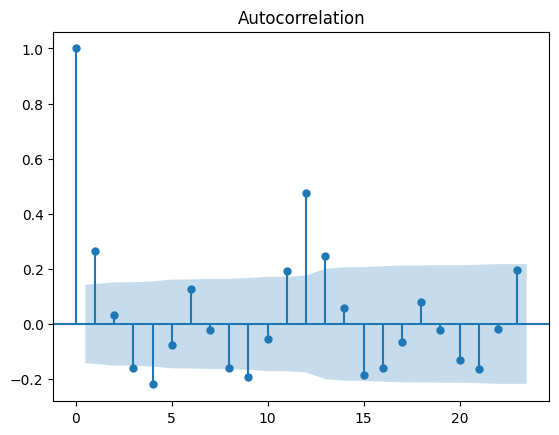

In [31]:
plot_acf(result_mr.resid)
plt.show()

### Fit sinusoidal

In [80]:
prices = ts.price.values
times  = np.arange(1,len(prices),1)

In [81]:
def model_cte(coefs,t):
    return prices[t-1] + coefs[0] +  coefs[1] * (np.sin((t+coefs[2])*2*np.pi/6))
    
def residuals_prices_cte(coefs):
    return model_cte(coefs, times[:]) - prices[1:]

def model_rever(coefs,t):
    return prices[t-1] + coefs[0] +  coefs[1] * prices[t-1] + coefs[2] * (np.sin((t+coefs[3])*2*np.pi/6))
    
def residuals_prices_rever(coefs):
    return model_rever(coefs, times[:]) - prices[1:]

num_coefs = 3
p0 = initial_values(num_coefs)
results_noncorrelated_residuals = NLS(residuals_prices_cte, p0, xdata=times, ydata=prices[1:])

num_coefs = 4
p0 = initial_values(num_coefs)
results_correlated_residuals = NLS(residuals_prices_rever, p0, xdata=times, ydata=prices[1:])

In [82]:
results_correlated_residuals.summary()

Non-linear least squares
Model: residuals_prices_rever
╒══════════╤══════════╤════════════╤═════════╤═════════╕
│ Variable │ Estimate │ Std. Error │ t-value │ P(>|t|) │
├──────────┼──────────┼────────────┼─────────┼─────────┤
│ coefs0   │ 0.4125   │ 0.1732     │ 2.3813  │ 0.0183  │
├──────────┼──────────┼────────────┼─────────┼─────────┤
│ coefs1   │ -0.0449  │ 0.0190     │ -2.3590 │ 0.0194  │
├──────────┼──────────┼────────────┼─────────┼─────────┤
│ coefs2   │ -0.1814  │ 0.0241     │ -7.5410 │ 0.0000  │
├──────────┼──────────┼────────────┼─────────┼─────────┤
│ coefs3   │ -1.1059  │ 0.1270     │ -8.7068 │ 0.0000  │
╘══════════╧══════════╧════════════╧═════════╧═════════╛
Residual Standard Error:  0.2343
Df: 187


In [83]:
results_noncorrelated_residuals.summary()

Non-linear least squares
Model: residuals_prices_cte
╒══════════╤══════════╤════════════╤═════════╤═════════╕
│ Variable │ Estimate │ Std. Error │ t-value │ P(>|t|) │
├──────────┼──────────┼────────────┼─────────┼─────────┤
│ coefs0   │ 0.0059   │ 0.0172     │ 0.3439  │ 0.7313  │
├──────────┼──────────┼────────────┼─────────┼─────────┤
│ coefs1   │ -0.1846  │ 0.0243     │ -7.5950 │ 0.0000  │
├──────────┼──────────┼────────────┼─────────┼─────────┤
│ coefs2   │ -1.0688  │ 0.1253     │ -8.5293 │ 0.0000  │
╘══════════╧══════════╧════════════╧═════════╧═════════╛
Residual Standard Error:  0.2371
Df: 188


In [271]:
np.savetxt('Models/coeficients/prices_cte.csv', results_noncorrelated_residuals.parmEsts, delimiter=',')
np.savetxt('Models/coeficients/prices_rever.csv', results_correlated_residuals.parmEsts, delimiter=',')

In [273]:
resid_struc    = - residuals_prices_cte(results_noncorrelated_residuals.parmEsts)
print(f'The standard error (without error structures) is: {np.std(resid_struc)}')

resid_unestruc = - residuals_prices_rever(results_correlated_residuals.parmEsts)
print(f'The standard error (with error structure) is: {np.std(resid_unestruc)}')

The standard error (without error structures) is: 0.23525918886981498
The standard error (with error structure) is: 0.23183635480506956


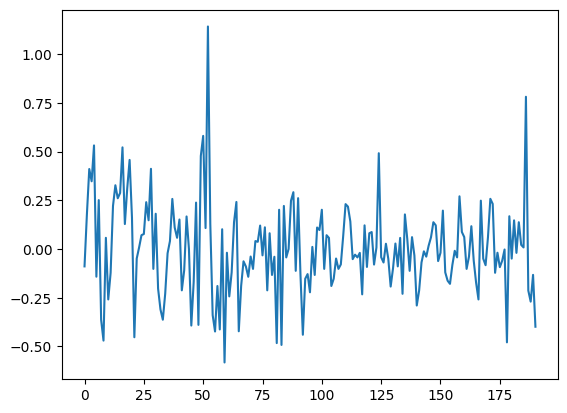

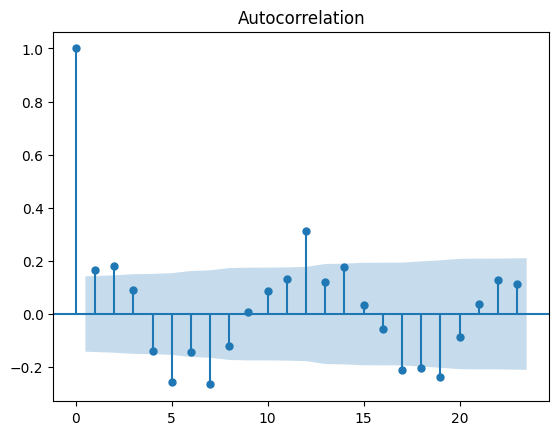

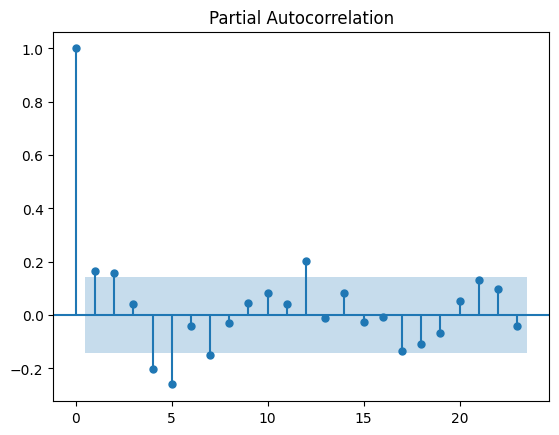

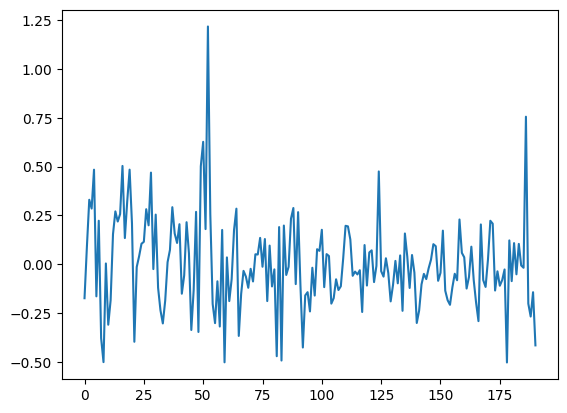

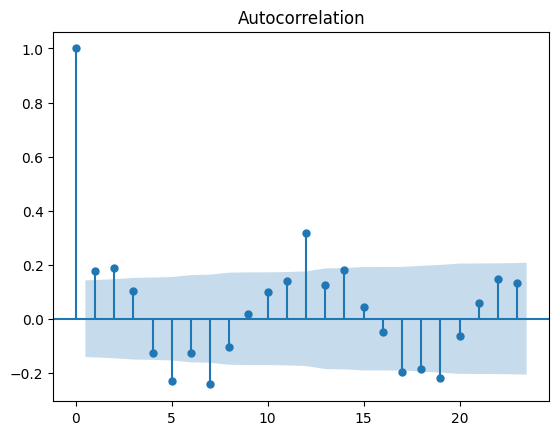

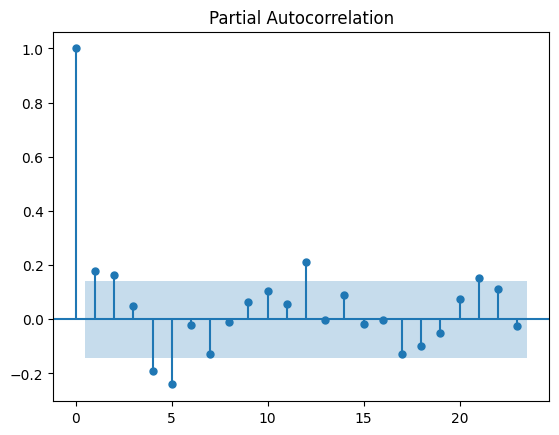

In [181]:
for resid in [resid_struc, resid_unestruc]:
    plt.plot(resid)
    plt.show()
    plot_acf(resid)
    plt.show()
    plot_pacf(resid)
    plt.show()

## IV-function implementation

### Preprocessing

In [33]:
prices_data = pd.read_csv('prices_processed.csv', index_col=0)
start = np.where(prices_data.index == 'Jan 2004')[0][0]
end   = np.where(prices_data.index == 'Jan 2020')[0][0]
new_prices = prices_data.iloc[start:end, -1].values

ts = pd.read_csv('Preprocessed_data/ts.csv')
ts.loc[:,'price'] = new_prices

log_diff_prices = ts.price.values
log_diff_prices = np.array(log_diff_prices, dtype=float)
log_diff_prices = np.diff(np.log(log_diff_prices))
log_diff_prices = np.concatenate((np.array([0]), log_diff_prices))
ts['log_diff_prices'] = log_diff_prices

yearmonth = list(ts['yearmonth'])
x_label   = data_tools.from_index_to_dates(yearmonth)

ts['X']                = np.zeros(ts.shape[0])
ts['price_residual']   = np.zeros(ts.shape[0])
ts['storage_residual'] = np.zeros(ts.shape[0])

for t in ts.index:
    if t == 0:
        continue
    #storage residuals
    
    pred_storage = model_storage(model_inflow, ts.loc[t-1,'inflow'] , model_evaporation, t, ts.loc[t-1,'storage'], ts.loc[t,'outflow'])
    
    ts.loc[t,'storage_residual'] = ts.loc[t,'storage'] - pred_storage
    
    #prices residuals
        
    curr_price = ts.loc[t  , 'price']
    prev_price = ts.loc[t-1, 'price']
    
    if t < 12:
        ts.loc[t,'X'] = residual(prev_price,curr_price,t)
        ts.loc[t,'price_residual'] = 0
        continue
     
    
    prev_x   = ts.loc[t-1 ,'X']
    prev_y_x = ts.loc[t-12,'X']
    
    ts.loc[t,'X'] = residual(prev_price, curr_price, t)
    
    expected_X = mean_rever(prev_x,prev_y_x)
    
    ts.loc[t,'price_residual'] = residual_with_X(prev_price,curr_price,expected_X,t)
    

# correlation between residuals:

storage_res = ts['storage_residual'].values
prices_res  = ts['price_residual'  ].values

correlation = np.corrcoef(ts['storage_residual'].values[12:], ts['price_residual'].values[12:])[0,1]

eta = 0.5
zd  = 105.69451612903225
r   = 0.0041

discount = 1/(1+r)

elev_stor = zip(ts.elevation.values,ts.storage.values)
elev_stor = sorted(elev_stor, key=lambda x: (x[1],x[0]))

### Function

In [34]:
def get_middle_points(x):
    x = np.array(x)
    return (x[:-1] + x[1:])/2


def pi_fun(storage, inflow, t, P, q, model_inflow, model_evaporation):
    
    expected_storage = model_storage(model_inflow, inflow , model_evaporation, t, storage, q) # this may not be needed if forecast is done.
    return eta * q * ((z(storage, elev_stor) + z(expected_storage,elev_stor))/2 - zd) * P

def pi_call_0(storage, inflow, t, P, q):
    if storage > 2e4 or storage < 3e4:
        return pi_fun(storage, inflow, t, P, q, model_inflow, model_evaporation) 
    else:
        return -1e7
    
def prepro_coord_array(x,y):
    
    cond_storage = np.logical_or(x<storage_grid[0], x>storage_grid[-1])
    x[x<storage_grid[0]]  = storage_grid[0]
    x[x>storage_grid[-1]] = storage_grid[-1]
    
    y[y<price_grid[0] ] = price_grid[0]
    y[y>price_grid[-1]] = price_grid[-1]
    cond_price = np.logical_or(x<price_grid[0], x>price_grid[-1])

    return x,y, cond_storage, cond_price


def future_payments(V,A,shocks_storage, shocks_price, input_next_storage, input_next_price, price_grid, storage_grid,boundaries,ts_forecast):
    K = len(shocks_storage)
    J = len(shocks_price  )
    
    future_payment = np.zeros((K,J))
        
    future_storage = next_storage(*input_next_storage, shocks_storage)
    cond = np.logical_or(future_storage < boundaries[0], future_storage > boundaries[1])
    
    ###################
    
    #future_price = next_price_cte(  *input_next_price  , shocks_price) # adjust the price model
    future_price = next_price_rever(  *input_next_price  , shocks_price) # adjust the price model
    
    ################3
    
    cond = np.meshgrid(cond,future_price)[0]
    
    under_storage = False
    over_storage  = False
    
    if future_storage.min() < boundaries[0]:
        under_storage = True
        over_storage  = False
        
    elif future_storage.max() > boundaries[1]:
        under_storage = False
        over_storage  = True
    
    
    future_storage, future_price, cond_storage, cond_price = prepro_coord_array(future_storage, future_price)
    future_storage_upper, future_price_upper = coord_array_upper(future_storage, future_price,cond_storage, cond_price) # at this point future_price is the coord in V
    future_storage_lower, future_price_lower = coord_array_lower(future_storage, future_price)
    future_storage_closest, future_price_closest = coord_array(future_storage, future_price) # at this point future_price is the coord in V
    
    #print(future_price_closest)
    
    future_storage_upper[cond_storage] = future_storage_closest[cond_storage]
    future_price_upper[cond_price] = future_price_closest[cond_price]
    future_storage_exact, future_price_exact = coord_array_exact(future_storage, future_price)
        
    weight_storage = np.ones(K) - future_storage_exact + future_storage_lower
    weight_price   = np.ones(J) - future_price_exact   + future_price_lower
    
    W_storage = np.outer(weight_storage, np.ones(K))
    W_price   = np.outer(weight_price,   np.ones(J))
    W = (W_storage + W_price)/2
    
    future_storage_lower_cd ,future_price_lower_cd = np.meshgrid(future_storage_lower, future_price_lower)
    future_storage_upper_cd ,future_price_upper_cd = np.meshgrid(future_storage_upper, future_price_upper)

    future_value = W * V[future_storage_lower_cd, future_price_lower_cd] + (-W + 1) * V[future_storage_upper_cd, future_price_upper_cd]
    
    future_payment = np.multiply(future_value, A)
    
    return np.sum(future_payment[~cond]), under_storage, over_storage

def action_value(input_next_storage, input_next_price, V0, A, shocks_storage, shocks_prices, price_grid, storage_grid, boundaries, ts_forecast):
    
    s_next = (s+1)
    next_state_value, under_storage, over_storage = future_payments(V0[s_next],A, shocks_storage, shocks_prices,
                                                            input_next_storage, input_next_price, 
                                                            price_grid, storage_grid, boundaries, ts_forecast)
    
    next_state_value = discount * next_state_value
    
    if under_storage or over_storage: 
        return 0 + next_state_value
    else:
        q = input_next_storage[-2]
        return pi_call_0(storage, inflow, current_time, price, q) + next_state_value
    
def save_load_policy_V0(policy = None, V0 = None, save_results = False, load_results = False, mr = False):

    if save_results and policy.any() and V0.any():

        if mr:
            policy.tofile('Results/policy_mr_model.txt')
            V0.tofile('Results/V0_mr_model.txt')

        else:
            policy.tofile('Results/policy_nonmr_model.txt')
            V0.tofile('Results/V0_nonmr_model.txt')

    if load_results:

        if mr:
            mr_file = open("Results/policy_mr_model.txt")
            loaded_policy = np.fromfile(mr_file)
            loaded_policy = loaded_policy.reshape((S,N,M))
            mr_file.close()

            V0_mr = open("Results/V0_mr_model.txt")
            loaded_V0 = np.fromfile(V0_mr)
            loaded_V0 = loaded_V0.reshape((S+1,N,M))
            V0_mr.close()

        else:
            nonmr_file = open("Results/policy_nonmr_model.txt")
            loaded_policy = np.fromfile(nonmr_file)
            loaded_policy = loaded_policy.reshape((S,N,M))
            nonmr_file.close()

            V0_nonmr = open("Results/V0_nonmr_model.txt")
            loaded_V0 = np.fromfile(V0_nonmr)
            loaded_V0 = loaded_V0.reshape((S+1,N,M))
            V0_nonmr.close()
            
        return loaded_policy, loaded_V0
    return None



coord = lambda x,y: (int((x - storage_grid[0])/step_storage) * step_storage + storage_grid[0], int((y - price_grid[0])/step_price) * step_price + price_grid[0])

coord_array = lambda x,y: (((x - storage_grid[0])/step_storage + 0.5).astype(int), ((y - price_grid[0])/step_price + 0.5).astype(int))

coord_array_exact = lambda x,y: ((x - storage_grid[0])/step_storage, (y - price_grid[0])/step_price)

coord_array_upper = lambda x,y,x_cond,y_cond: (((x - storage_grid[0])/step_storage + 1*(~x_cond)).astype(int), ((y - price_grid[0])/step_price + 1*(~y_cond)).astype(int))

coord_array_lower = lambda x,y: (((x - storage_grid[0])/step_storage).astype(int), ((y - price_grid[0])/step_price ).astype(int))


@jit
def pi_fun_numba(storage, inflow, t, P, q):
    inflow  = coefs_inflow[0] + coefs_inflow[1]* inflow + coefs_inflow[2] * (np.sin((t+coefs_inflow[3])*2*np.pi/12))
    evapor  = coefs_evaporation[0] + coefs_evaporation[1] * np.sin((coefs_evaporation[2]+t)*2*np.pi/12) 
    expected_storage = storage + 2.592 * inflow - evapor -  2.592 * q
    return eta * q * ((z_numba(storage, elev_stor) + z_numba(expected_storage,elev_stor))/2 - zd) * P

@jit
def z_numba(I,elev_stor):
    if I <= elev_stor[0,1]:
        return elev_stor[0,0]

    if I >= elev_stor[-1,1]:
        return elev_stor[-1,0]

    for idx in range(1,len(elev_stor)):
        prev_storage = elev_stor[idx-1][1]
        curr_storage = elev_stor[idx][1]

        if prev_storage == curr_storage:
            continue

        if I >= prev_storage and I < curr_storage:
            prev_height = elev_stor[idx-1][0]
            curr_height = elev_stor[idx][0]

            return prev_height   + (curr_height-prev_height) * (I - prev_storage)/(curr_storage-prev_storage)


@jit
def meshgrid_numba(x, y):
    xx = np.empty(shape=(x.size, y.size), dtype=x.dtype)
    yy = np.empty(shape=(x.size, y.size), dtype=y.dtype)
    for j in range(y.size):
        for k in range(x.size):
            xx[j,k] = x[k]  # change to x[k] if indexing xy
            yy[j,k] = y[j] 
    return xx, yy

@jit
def coord_array_numba(x,y):
    return (((x - storage_grid[0])/step_storage + 0.5).astype(np.int_), ((y - price_grid[0])/step_price + 0.5).astype(np.int_))

@jit
def coord_array_exact_numba(x,y):
    return ((x - storage_grid[0])/step_storage, (y - price_grid[0])/step_price)

@jit
def coord_array_upper_numba(x,y,x_cond,y_cond):
    return (((x - storage_grid[0])/step_storage + 1*(~x_cond)).astype(np.int_), ((y - price_grid[0])/step_price + 1*(~y_cond)).astype(np.int_))

@jit
def coord_array_lower_numba(x,y):
    return (((x - storage_grid[0])/step_storage).astype(np.int_), ((y - price_grid[0])/step_price ).astype(np.int_))

@jit
def prepro_coord_array_numba(x,y):
    
    cond_storage = np.logical_or(x<storage_grid[0], x>storage_grid[-1])
    x[x<storage_grid[0]]  = storage_grid[0]
    x[x>storage_grid[-1]] = storage_grid[-1]
    
    y[y<price_grid[0] ] = price_grid[0]
    y[y>price_grid[-1]] = price_grid[-1]
    cond_price = np.logical_or(x<price_grid[0], x>price_grid[-1])

    return x,y, cond_storage, cond_price

@jit
def next_storage_numba(prev_inflow, t, prev_storage, outflow, shock_n):
    inflow  = coefs_inflow[0] + coefs_inflow[1]* prev_inflow + coefs_inflow[2] * (sin((t+coefs_inflow[3])*2*pi/12))
    evapor  = coefs_evaporation[0] + coefs_evaporation[1] * sin((coefs_evaporation[2]+t)*2*pi/12) 
    storage = prev_storage + 2.592 * inflow - evapor -  2.592 * outflow
    return storage + storage_sd * shock_n

@jit
def model_prices_rever_numba(t,prev):
    return prev + coefs_prices_rever[0] +  coefs_prices_rever[1] * prev + coefs_prices_rever[2] * (np.sin((t+coefs_prices_rever[3])*2*np.pi/6))

@jit
def model_prices_cte_numba(t, prev):
    return prev + coefs_prices_cte[0] +  coefs_prices_cte[1] * (np.sin((t+coefs_prices_cte[2])*2*np.pi/6))

@jit
def next_price_rever_numba(t, prev, shock_m):
    return model_prices_rever_numba(t, prev)  + prices_rever_sd * shock_m
@jit
def next_price_cte_numba(t, prev, shock_m):
    return model_prices_cte_numba(t, prev)  + prices_cte_sd * shock_m


@jit
def gridding(future_storage, future_price):
    future_storage,         future_price, cond_storage, cond_price = prepro_coord_array_numba(future_storage, future_price)
    future_storage_upper,   future_price_upper                     = coord_array_upper_numba(future_storage, future_price,cond_storage, cond_price) # at this point future_price is the coord in V
    future_storage_lower,   future_price_lower                     = coord_array_lower_numba(future_storage, future_price)
    future_storage_closest, future_price_closest                   = coord_array_numba(future_storage, future_price) # at this point future_price is the coord in V
    
    #print(future_price_closest)
    
    future_storage_upper[cond_storage] = future_storage_closest[cond_storage]
    future_price_upper[cond_price] = future_price_closest[cond_price]
    future_storage_exact, future_price_exact = coord_array_exact_numba(future_storage, future_price)
        
    weight_storage = np.ones(K) - future_storage_exact + future_storage_lower
    weight_price   = np.ones(J) - future_price_exact   + future_price_lower
    
    W_storage = np.outer(weight_storage, np.ones(K))
    W_price   = np.outer(weight_price,   np.ones(J))
    W = (W_storage + W_price)/2
    
    future_storage_lower_cd ,future_price_lower_cd = meshgrid_numba(future_storage_lower, future_price_lower)
    future_storage_upper_cd ,future_price_upper_cd = meshgrid_numba(future_storage_upper, future_price_upper)
    
    return future_storage_lower_cd, future_price_lower_cd, future_storage_upper_cd, future_price_upper_cd, W

@jit
def future_payments_numba(V,A,shocks_storage, shocks_price, inflow, current_time, 
                          storage, q, price, price_grid, storage_grid,boundaries):
    
    #future_payment = np.zeros((K,J))
        
    future_storage = next_storage_numba(inflow, current_time, storage, q, shocks_storage)
    cond = np.logical_or(future_storage < boundaries[0], future_storage > boundaries[1])
    
    ###################
    
    future_price = next_price_cte_numba( current_time, price  , shocks_price) # adjust the price model
    #future_price = next_price_rever_numba(current_time, price  , shocks_price) # adjust the price model
    
    ###################
    
    cond = meshgrid_numba(cond,future_price)[0]
    
    under_storage = False
    over_storage  = False
    
    if future_storage.min() < boundaries[0]:
        under_storage = True
        over_storage  = False
        
    elif future_storage.max() > boundaries[1]:
        under_storage = False
        over_storage  = True
    
    
    future_storage_lower_cd, future_price_lower_cd, future_storage_upper_cd, future_price_upper_cd, W = gridding(future_storage, future_price)
    
    future_value = np.zeros((K,J))
    for idx_storage,_ in enumerate(future_storage_lower_cd[0,:]):
        for idx_price,_ in enumerate(future_price_lower_cd[:,0]):
            future_value[idx_storage,idx_price] = (W[idx_storage, idx_price] * V[future_storage_lower_cd[0,idx_price],future_price_lower_cd[idx_storage,0] ] + 
            (1-W[idx_storage, idx_price]) * V[future_storage_upper_cd[0,idx_price],future_price_upper_cd[idx_storage,0]])
    
    future_payment = np.multiply(future_value, A)

    sol = 0
    for x in range(cond.shape[0]):
        for y in range(cond.shape[1]):
             if np.logical_not(cond[x,y]):
                sol += future_payment[x,y]

    return sol, under_storage, over_storage
    
@jit
def action_value_numba(s, inflow, current_time, storage, q, price, V0, A, shocks_storage,
                                                shocks_prices, price_grid, storage_grid, boundaries):
    
    s_next = s+1
    next_state_value, under_storage, over_storage = future_payments_numba(V0[s_next],A, shocks_storage, shocks_prices,
                                                            inflow, current_time, storage, q, price, price_grid,
                                                                    storage_grid, boundaries)
    
    next_state_value = discount * next_state_value
    
    if under_storage or over_storage: 
        return 0 + next_state_value
    else:
        return pi_fun_numba(storage, inflow, current_time, price, q) + next_state_value

@jit
def iv_algo(policy, V0, V1):
    for s in range(S):
        current_time = time_0 + s
        inflow       = inflow_values[current_time]

        for n in range(N):
            storage      = storage_grid[n]

            for m in range(M):
                price = price_grid[m]
                rewards = np.zeros(L+1)
                i = 0
                #input_next_storage = [model_inflow, inflow , model_evaporation, current_time,
                #          storage, 0, model_storage]

                input_next_price   = np.array([current_time, price])
                
                for q in outflow_grid:

                    rewards[i] = (action_value_numba(s, inflow, current_time,
                                                storage, q, price, V0, A, shocks_storage,
                                                shocks_prices, price_grid, storage_grid, boundaries))
                    i+=1

                policy[s,n,m] = outflow_grid[np.argmax(rewards)]
                V1[s,n,m]     = np.max(rewards)
                
    return policy, V1

### Parameters

In [35]:
N = 80 # For the storage grid
M = 100 # For the price grid
L = 30 # For the outflow grid
S = 30 # For the states

discount = 1/(1+r)

P_min = 6.5
P_max = 11

I_min = 1750
I_max = 3250
boundaries = np.array([2000,3000])

q_min = 0
q_max = 245

price_grid   = get_middle_points(np.arange(P_min, P_max+ 2**-15, (P_max - P_min)/M))
storage_grid = get_middle_points(np.arange(I_min, I_max+ 2**-15, (I_max - I_min)/N))


rho = 2.33
K = 20 # number of shocks in the storage grid
J = 20 # number of shocks in the prices grid

shocks_storage  = get_middle_points(np.arange(-rho, rho+2**-15, (2*rho)/ K))

dist_shocks_storage = (shocks_storage[1] - shocks_storage[0])/2
prob_shocks_storage = norm.cdf(shocks_storage[:] + dist_shocks_storage) - norm.cdf(shocks_storage[:] - dist_shocks_storage)

shocks_prices  = get_middle_points(np.arange(-rho, rho+2**-15, (2*rho)/ J))

dist_shocks_prices = (shocks_prices[1] - shocks_prices[0])/2
prob_shocks_prices = norm.cdf(shocks_prices[:] + dist_shocks_prices) - norm.cdf(shocks_prices[:] - dist_shocks_prices)



outflow_grid = np.arange(q_min, q_max+ 2**-15, (q_max - q_min)/L) # L+1 elements

V0 = np.zeros((S+1,N,M))
V1 = np.zeros((S+1,N,M))

policy = np.zeros((S,N,M))

step_price   = price_grid[1]   - price_grid[0]
step_storage = storage_grid[1] - storage_grid[0]

### Forecast state variables

In [36]:
time_0 = ts.shape[0]
ts_forecast = ts.copy()

for i in range(S):
    
    current_time = time_0 + i
    
    prev_inflow  = ts_forecast.loc[current_time - 1, 'inflow' ]
    prev_storage = ts_forecast.loc[current_time - 1, 'storage']
    
    current_storage = model_storage(model_inflow,prev_inflow, model_evaporation, current_time, prev_storage, prev_inflow)
    current_inflow  = model_inflow(prev_inflow, current_time)
    
    ts_forecast.loc[current_time,'storage'] = current_storage
    ts_forecast.loc[current_time,'inflow']  = current_inflow
    
# Forecasting Prices M steps ahead
for i in range(S):
    
    current_time = time_0 + i
    
    prev     = ts_forecast.loc[current_time-1,  'price']
    #prev_x   = ts_forecast.loc[current_time-1,  'X']
    #prev_y_x = ts_forecast.loc[current_time-12, 'X']
    
    ############## update this line in case of modifying the price function
    
    #curr_price = model_prices_cte(current_time, prev)
    curr_price = model_prices_rever(current_time, prev)

    ##############
    
    ts_forecast.loc[current_time,'price'] = curr_price
    
    #X = residual(prev,curr_price,current_time)
    #ts_forecast.loc[current_time,'X'] = X

### Running the IV-function algorithm

#### IV with numba

In [37]:
inflow_values = ts_forecast.inflow.values

coefs_inflow = loadtxt('Models/coeficients/inflow_coef.csv')
coefs_evaporation = loadtxt('Models/coeficients/evaporation.csv')

elev_stor = np.array(elev_stor)

In [38]:
max_ite = 10
ite     = 0
tol     = 2**-15

A = np.outer(prob_shocks_storage,prob_shocks_prices)


t0 = time()
while ite < max_ite:

    policy, V1 = iv_algo(policy, V0, V1)

    error = np.max(np.abs(V0-V1))/np.max(V1)
    if error < tol:
        V0 = V1.copy()
        print(time()-t0)
        print(f'Iteration: {ite}')
        print(f'Error is: {error}')
        break

    V0   = V1.copy()
    ite += 1
    print(time()-t0)
    print(f'Iteration: {ite}')
    print(f'Error is: {error}')
    print('='*50)

71.71599102020264
Iteration: 1
Error is: 1.0
133.32808566093445
Iteration: 2
Error is: 0.4799708580245656
194.74764108657837
Iteration: 3
Error is: 0.24796484760907944
256.02708172798157
Iteration: 4
Error is: 0.12342351678065258
317.540812253952
Iteration: 5
Error is: 0.10593834450807361
379.0959541797638
Iteration: 6
Error is: 0.09377951608470858
441.0292344093323
Iteration: 7
Error is: 0.08456017568739226
503.2800714969635
Iteration: 8
Error is: 0.07745637920707465
565.609664440155
Iteration: 9
Error is: 0.07160225707838212
626.9076724052429
Iteration: 10
Error is: 0.06685581325259637


In [39]:
save_load_policy_V0(policy=policy, V0= V0, mr = False, save_results = True)

#### IV classic

In [372]:
max_ite = 2
ite     = 0
tol     = 2**-15

A = np.outer(prob_shocks_storage,prob_shocks_prices)


t0 = time()
while ite < max_ite:

    for s in range(S):
        current_time = time_0 + s
        inflow       = ts_forecast.loc[current_time,'inflow']

        for n in range(N):
            storage      = storage_grid[n]

            for m in range(M):
                price = price_grid[m]
                rewards = []

                input_next_storage = [model_inflow, inflow , model_evaporation, current_time,
                          storage, 0, model_storage]

                input_next_price   = [current_time, price]

                for q in outflow_grid:

                    input_next_storage[-2] = q

                    rewards.append(action_value(input_next_storage, input_next_price, V0, A, shocks_storage, shocks_prices, price_grid, storage_grid, boundaries, ts_forecast))

                policy[s,n,m] = outflow_grid[np.argmax(rewards)]
                V1[s,n,m]     = np.max(rewards) 

    error = np.max(np.abs(V0-V1))/np.max(V1)
    if error < tol:
        V0 = V1.copy()
        print(time()-t0)
        print(f'Iteration: {ite}')
        print(f'Error is: {error}')
        break

    V0   = V1.copy()
    ite += 1
    print(time()-t0)
    print(f'Iteration: {ite}')
    print(f'Error is: {error}')
    print('='*50)

29.878965377807617
Iteration: 1
Error is: 1.0
59.781604051589966
Iteration: 2
Error is: 0.47708389779760585


### Plots 

#### Functions

In [9]:
def plot_policy(storage_grid, price_grid, policy):
    x,y = np.meshgrid(storage_grid, price_grid)
    policy = np.transpose(policy)
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    ax.plot_surface(x,y,policy, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    ax.view_init(30, 230)
    ax.set_xlabel('storage (MCM)')
    ax.set_ylabel('price ($/kwh)')
    ax.set_zlabel('outflow (m^3/s)')
#     ax.set_title('Optimal policy (outflow) for different prices \n and storages at a given time (03/2020)')
#     ax.set_title('Optimal policy (outflow) for different prices \n and storages at a given time (06/2020)')
#     ax.set_title('Optimal policy (outflow) for different prices \n and storages at a given time (09/2020)')
#     plt.savefig('Figures/3d_03_non_mr.pdf', format='pdf')
#     plt.savefig('Figures/3d_06_non_mr.pdf', format='pdf')
#     plt.savefig('Figures/3d_09_non_mr.pdf', format='pdf')
    plt.show()
    
def plot_value(storage_grid, price_grid, value):
    x,y = np.meshgrid(storage_grid, price_grid)
    value = np.transpose(value)
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    ax.plot_surface(x,y,value, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    ax.view_init(30, 230)
    ax.set_xlabel('storage (MCM)')
    ax.set_ylabel('price ($/kwh)')
    ax.set_zlabel('Value')
    plt.show()

#### Figures

<ipython-input-9-35d55cf16015>:25: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


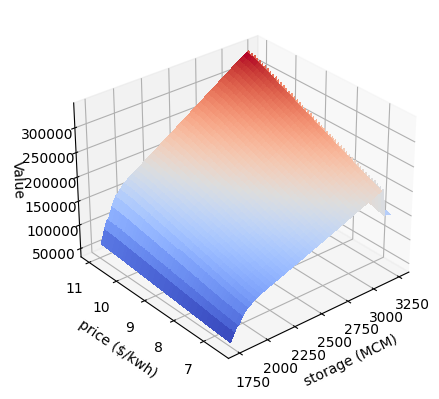

In [40]:
plot_value(storage_grid, price_grid, V0[0])

<ipython-input-9-35d55cf16015>:5: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


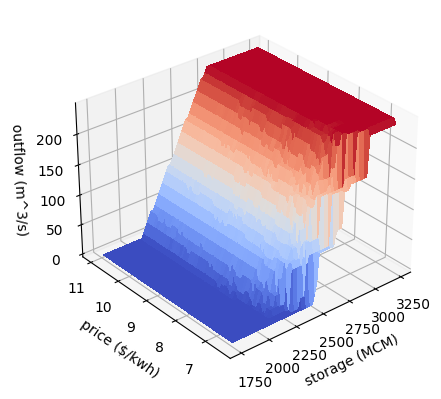

In [27]:
plot_policy(storage_grid,price_grid,policy[10])

<ipython-input-9-35d55cf16015>:5: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


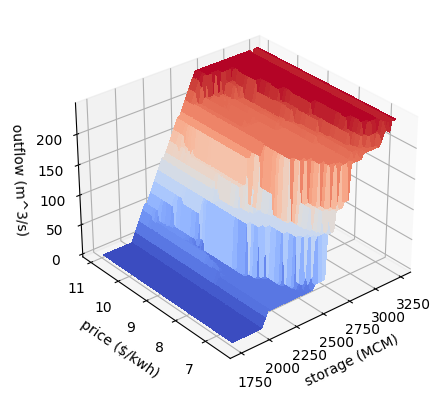

8.486897839842177


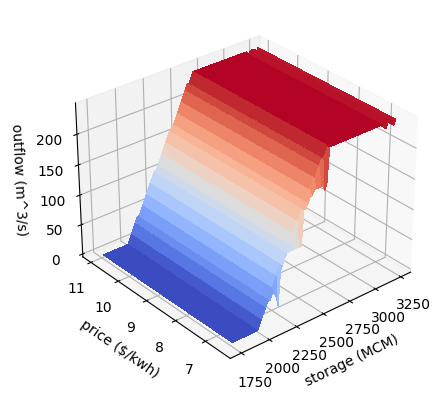

8.53841185500332


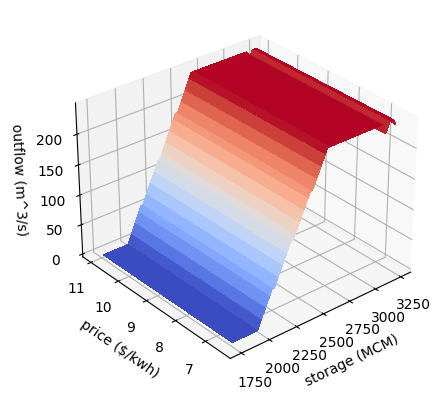

8.421443051041546


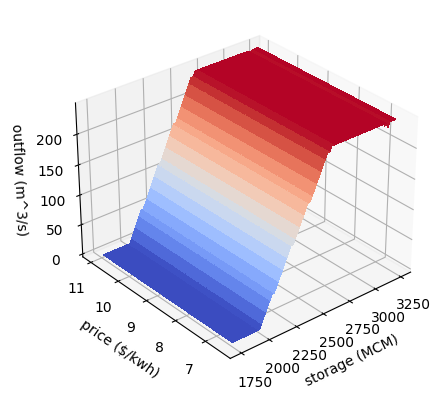

8.289650418207602


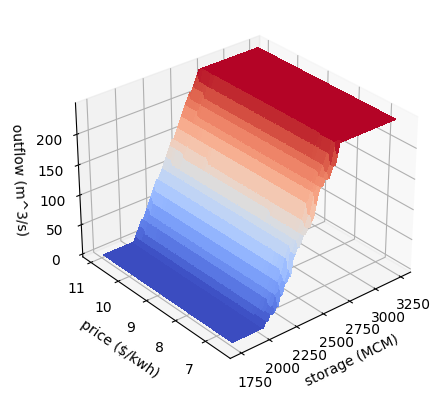

8.309869386260022


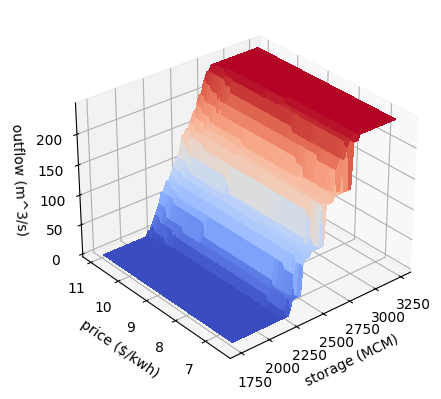

8.495350362489068


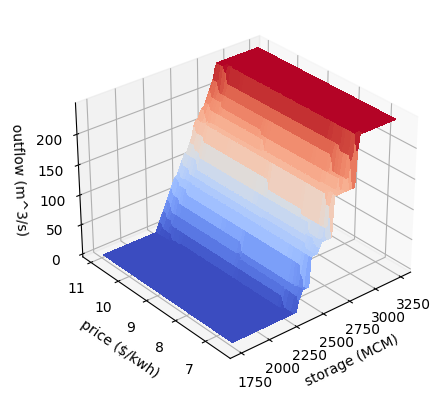

8.692578971055488


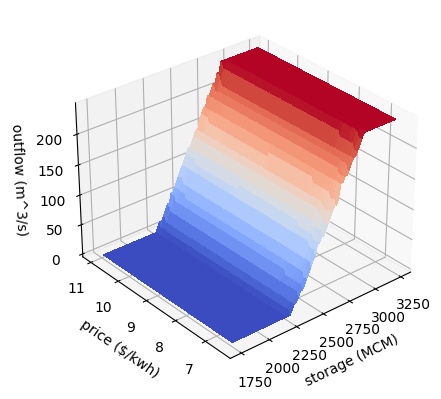

8.734857903425157


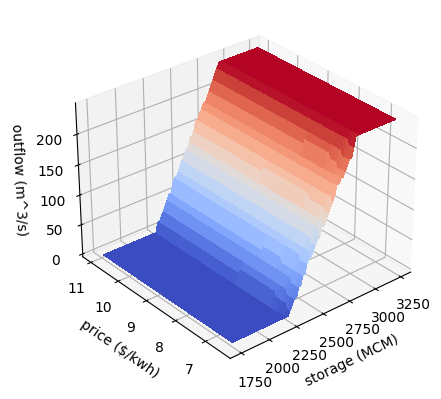

8.609068671889244


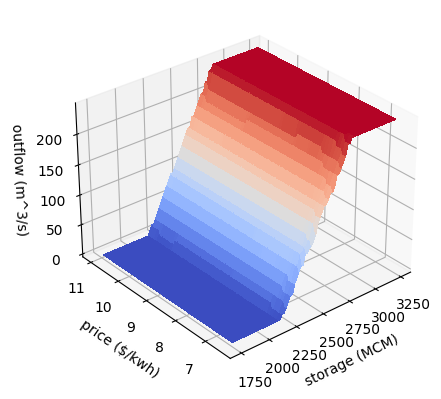

8.468851648679237


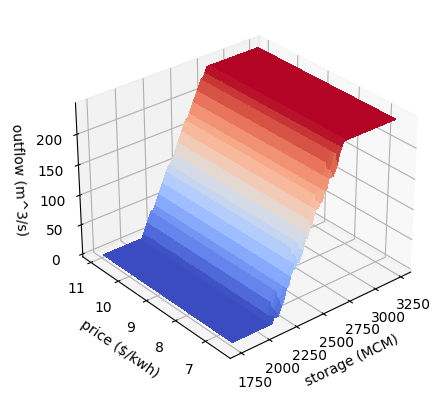

8.481024481483487


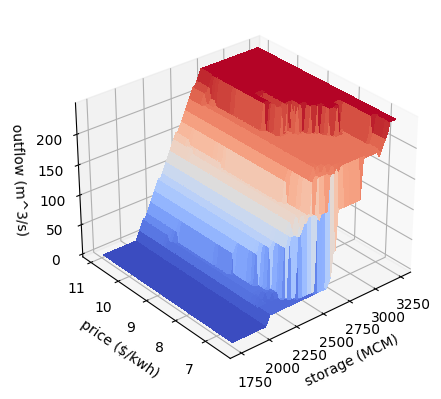

8.658820593937


In [41]:
for s in range(12):
    plot_policy(storage_grid,price_grid,policy[s])
    print(ts_forecast.loc[time_0+s, 'price'])

## Simulation of optimal policy

In [42]:
loaded_policy, loaded_strategy = save_load_policy_V0(mr = False, load_results = True)

In [43]:
def simulating_paths(loaded_policy,T = 10000, t0 = time_0, storage_0 = ts_forecast.loc[time_0 - 1, 'storage'], price_0 = ts_forecast.loc[time_0 - 1, 'price'], inflow_0 = ts_forecast.loc[time_0 - 1, 'inflow']):
    z_s = np.random.randn(T,S)
    z_p_hat = np.random.randn(T,S)
    z_p = correlation * z_s + np.sqrt(1-correlation**2) * z_p_hat

    storage = np.zeros((T,S+1))
    storage[:,0] = storage_0
    
    inflow = np.zeros((T,S+1))
    inflow[:,0] = inflow_0
    
    price = np.zeros((T,S+1))
    price[:,0] = price_0

    outflows_grid = np.zeros((T,S))

    previous_residuals_storage = np.zeros((T,S))

    for s in range(S):
        current_time = time_0 + s

        if s == 0:
            prev_x   = np.zeros(T) + ts_forecast.loc[time_0-1 , 'X']
            prev_y_x = np.zeros(T) + ts_forecast.loc[time_0-12, 'X']

        elif s < 12:
            prev_x   = previous_residuals_storage[:,s]
            prev_y_x = np.zeros(T) + ts_forecast.loc[current_time - 12, 'X']

        else:
            prev_x   = previous_residuals_storage[:, s-1]
            prev_y_x = previous_residuals_storage[:, s-12]

        
        storage_coord, price_coord, _, _ = prepro_coord_array(storage[:,s], price[:,s])
        storage_coord, price_coord = coord_array(storage_coord, price_coord) # at this point future_price is the coord in V
        
        
        outflows = loaded_policy[s,:,:][storage_coord, price_coord]
        outflows_grid[:,s] = outflows
        
        #print(outflows)
        
        input_next_storage = [model_inflow, ts_forecast.loc[current_time - 1,'inflow'] , model_evaporation, current_time,
                                              storage[:,s], outflows, model_storage] # Outflow changed from IV loop


        storage[:,s+1] = next_storage(*input_next_storage, z_s[:,s])
        inflow[:, s+1] = model_inflow(inflow[:,s], current_time)
        price[:,s+1]   = next_price_cte(current_time, price[:,s], z_p[:,s])

        previous_residuals_storage[:, s] = 0 # np.log(price[:,s+1] / next_price_mr(t,price[:,s], 0))
    
    return storage, price, outflows_grid, inflow

def plot_conf_int_boot(sample, quantiles = [0.05, 0.95], var_name = 'noname'):

    T = sample.shape[0]
    S = sample.shape[1]

    i_5  = int(T*quantiles[0])
    i_95 = int(T*quantiles[1])
    i_50 = int(T*0.5)

    top = np.zeros(S)
    med = np.zeros(S)
    bot = np.zeros(S)

    for t in range(S):

        sample_t = sorted(sample[:,t])

        top[t] = sample_t[i_95]
        med[t] = sample_t[i_50]
        bot[t] = sample_t[i_5]


    fig, (ax) = plt.subplots(1, 1, sharex=True)

    x = range(S)
    ax.plot(x, med , color='black', label = 'Median')
    ax.fill_between(x, bot, top, where=top >= bot, facecolor='green', interpolate=True, alpha = 0.6, label= '5% - 95% confidence interval')
    plt.legend()
    plt.title(f'Forward simulation: {T} trajectories ',fontdict={'size':'18'})
    plt.ylabel(var_name,fontdict={'size':'16'})
    plt.xlabel('Months',fontdict={'size':'16'})
    plt.grid()
    plt.tight_layout()
    
    return None
    

In [44]:
storage_sim, price_sim, outflows_sim, _ = simulating_paths(loaded_policy= loaded_policy)

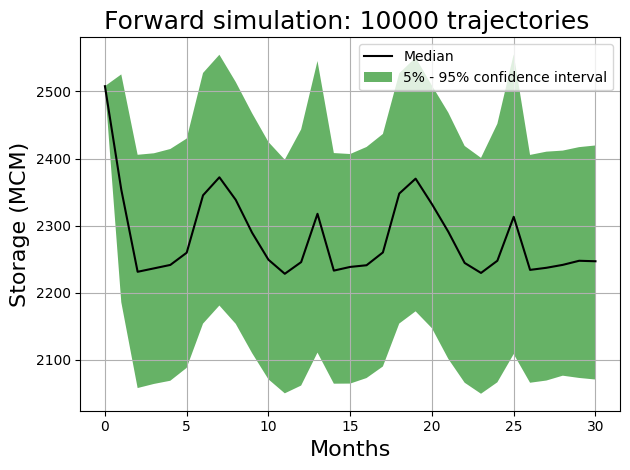

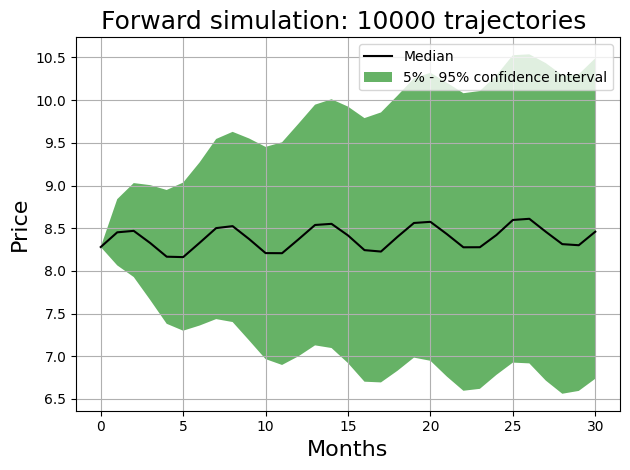

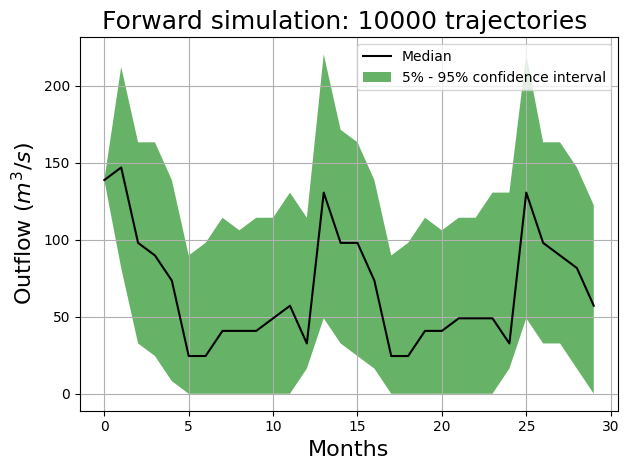

In [45]:
plot_conf_int_boot(storage_sim, var_name = 'Storage (MCM)')
#plt.savefig('Figures/storage_conf_int.pdf', format='pdf')
plt.show()
plot_conf_int_boot(price_sim, var_name = 'Price' )
#plt.savefig('Figures/price_conf_int.pdf', format='pdf')
plt.show()
plot_conf_int_boot(outflows_sim, var_name = 'Outflow ($m^3/s$)')
#plt.savefig('Figures/outflow_conf_int.pdf', format='pdf')
plt.show()

# Testing Area 

In [45]:
forecast = []
last_price = 0.05

for t in range(20):
    next_price = next_price_mr(0,last_price,0)
    forecast.append(next_price)
    last_price = next_price

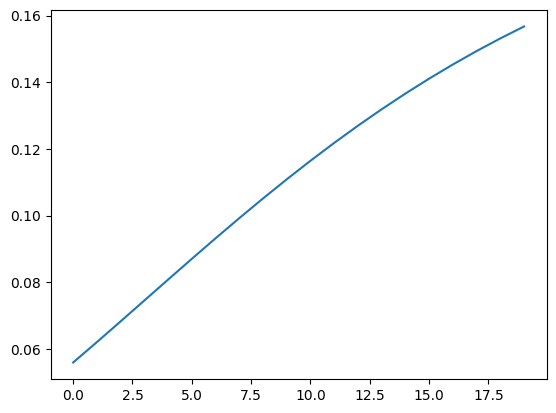

In [46]:
plt.plot(forecast)
plt.show()

In [47]:
coefs_log_prices_mr

array([-0.12701252, -0.06166215])

In [48]:
coefs_log_prices_mr

array([-0.12701252, -0.06166215])

In [49]:
np.exp(-0.12701252 * (1/(1-(1 - 0.08))))

0.2044040718219453